# Part 1: Depth Estimation

## Task

"Implement any model and training + evaluation script on NYU Depth V2 (available in TFDS → https://www.tensorflow.org/datasets/catalog/nyu_depth_v2, so TensorFlow is probably better way to complete this assessment; but if you would prefer PyTorch, feel free to pick any Depth Estimation dataset that you may find). The model architecture should not be sophisticated or very complex, so feel free to pick any tiny architecture that should work from your point of view. The same for the training config and optimizer to use, but please demonstrate how to use different optimizers and callbacks, in particular learning rate scheduler."

## Approach

### Dataset

Using the 🤗 HuggingFace version of NYU-Depth V2 dataset.

In [1]:
import torch, torch.nn as nn, torch.utils.data as data, torchvision as tv, torch.nn.functional as F
from torchvision.transforms import v2
from lightning.pytorch import loggers as pl_loggers
import lightning as L
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import dataclasses
from typing import List
from includes.metrics import DepthMetrics, evaluate_depth_metrics

In [2]:
cmap = plt.cm.viridis

ds = load_dataset("sayakpaul/nyu_depth_v2", trust_remote_code=True)

In [3]:
ds['train'].features

{'image': Image(decode=True, id=None),
 'depth_map': Image(decode=True, id=None)}

In [4]:
# Splitting the training data into training + validation (for training) so we can keep the 654 items for testing
# using a tiny split for quick evaluation (1/100th of dataset size)
ds_train, ds_validation, _ = random_split(ds["train"], (0.0085, 0.0015, 0.99)) # use built-in method in datasets.Dataset.train_test_split in future
ds_test = ds['validation']

In [5]:
len(ds_train), len(ds_validation), len(ds_test)

(405, 71, 654)

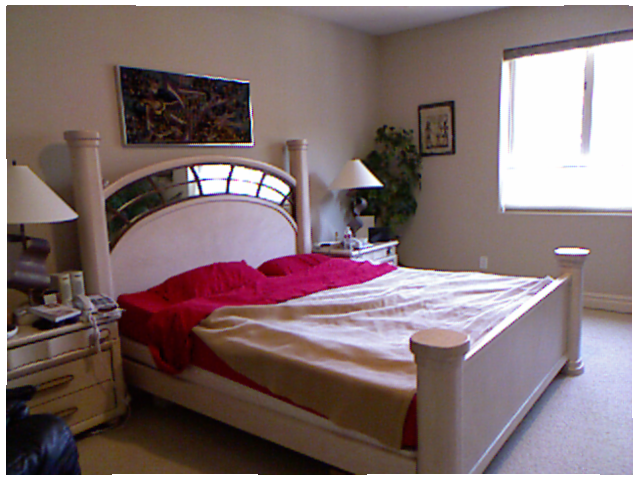

In [6]:
image, depth_mask = ds_train[42].values()
image

In [32]:
# Only basic transforms for assessment project, different for mask and image
transforms_mask = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    ]
)

In [8]:
transforms_image = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input   
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
def my_transforms(examples):
    examples['image'] = transforms_image(examples['image'])
    examples['depth_map'] = transforms_mask(examples['depth_map'])
    return examples

In [10]:
def colored_depthmap(depth, d_min=None, d_max=None):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C


def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

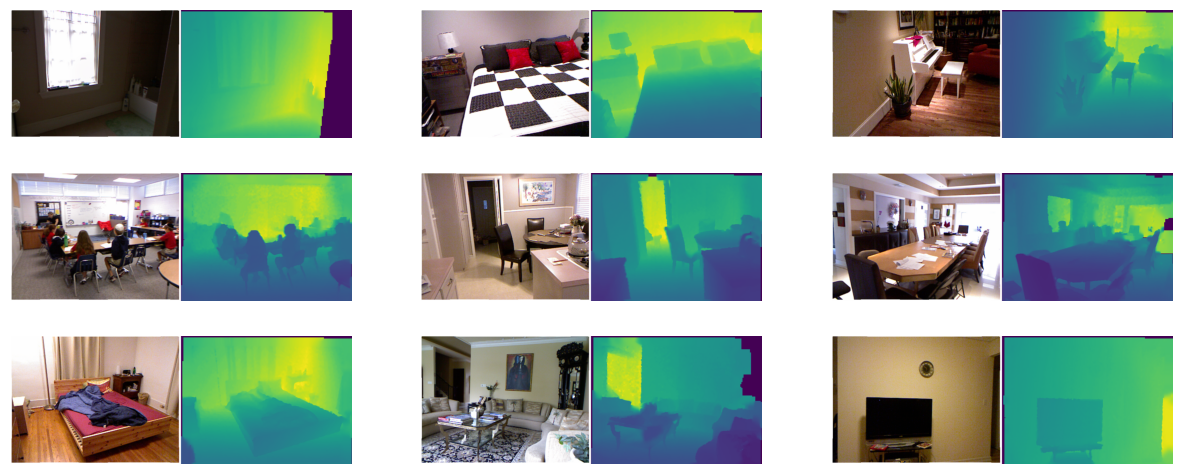

In [11]:
random_indices = np.random.choice(len(ds["train"]), 9).tolist()
train_set = ds["train"]

plt.figure(figsize=(15, 6))

for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    image_viz = merge_into_row(
        train_set[idx]["image"], train_set[idx]["depth_map"]
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

### Model

I chose [PyTorch Lightning](https://github.com/Lightning-AI/pytorch-lightning) for this task. Lightning comes with several advantages over unstructured PyTorch (from their repo):

* Models become hardware agnostic
* Code is clear to read because engineering code is abstracted away
* Easier to reproduce
* Make fewer mistakes because lightning handles the tricky engineering
* Keeps all the flexibility (LightningModules are still PyTorch modules), but removes a ton of boilerplate
* Lightning has dozens of integrations with popular machine learning tools.
* Minimal running speed overhead (about 300 ms per epoch compared with pure PyTorch).


For the "use different optimizers and callbacks, in particular learning rate scheduler" parts of the task in my experience often there's not a huge difference between the top-performers. I provide a simple choice between three basic configurations in this notebook. If I wanted to work through a larger search space for optimal results I'd proceed similar to hyperparameter search:

In a previous audio classification project I came upon [this very insightful report](https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-Tuning-ResNet-18-for-Audio-Classification--VmlldzoyOTAyMzc). The report shows how various (mostly audio-specific) hyperparameters (hop_length, win_length, n_mels, n_fft, ..., n_epochs, batch_size) have been tested strategically. wandb.ai offers a simple and straightforward way to track such experiments.

### Tasks:

- [x] build UNet with right input + output for dataset; (adaptation of [monodepth-dev](https://github.com/karasawatakumi/monodepth-dev))
- [x] decide on loss function
- [x] transforms (use torchvision transforms v2 for improved speed)
- [x] demonstration of different callbacks (Optimizer, LR Scheduler, Tensorboard logging ([on-validation-epoch end callback](https://lightning.ai/docs/pytorch/stable/extensions/callbacks.html#on-validation-epoch-end)))

### Loss graph (from Tensorboard, MPS accelerator)

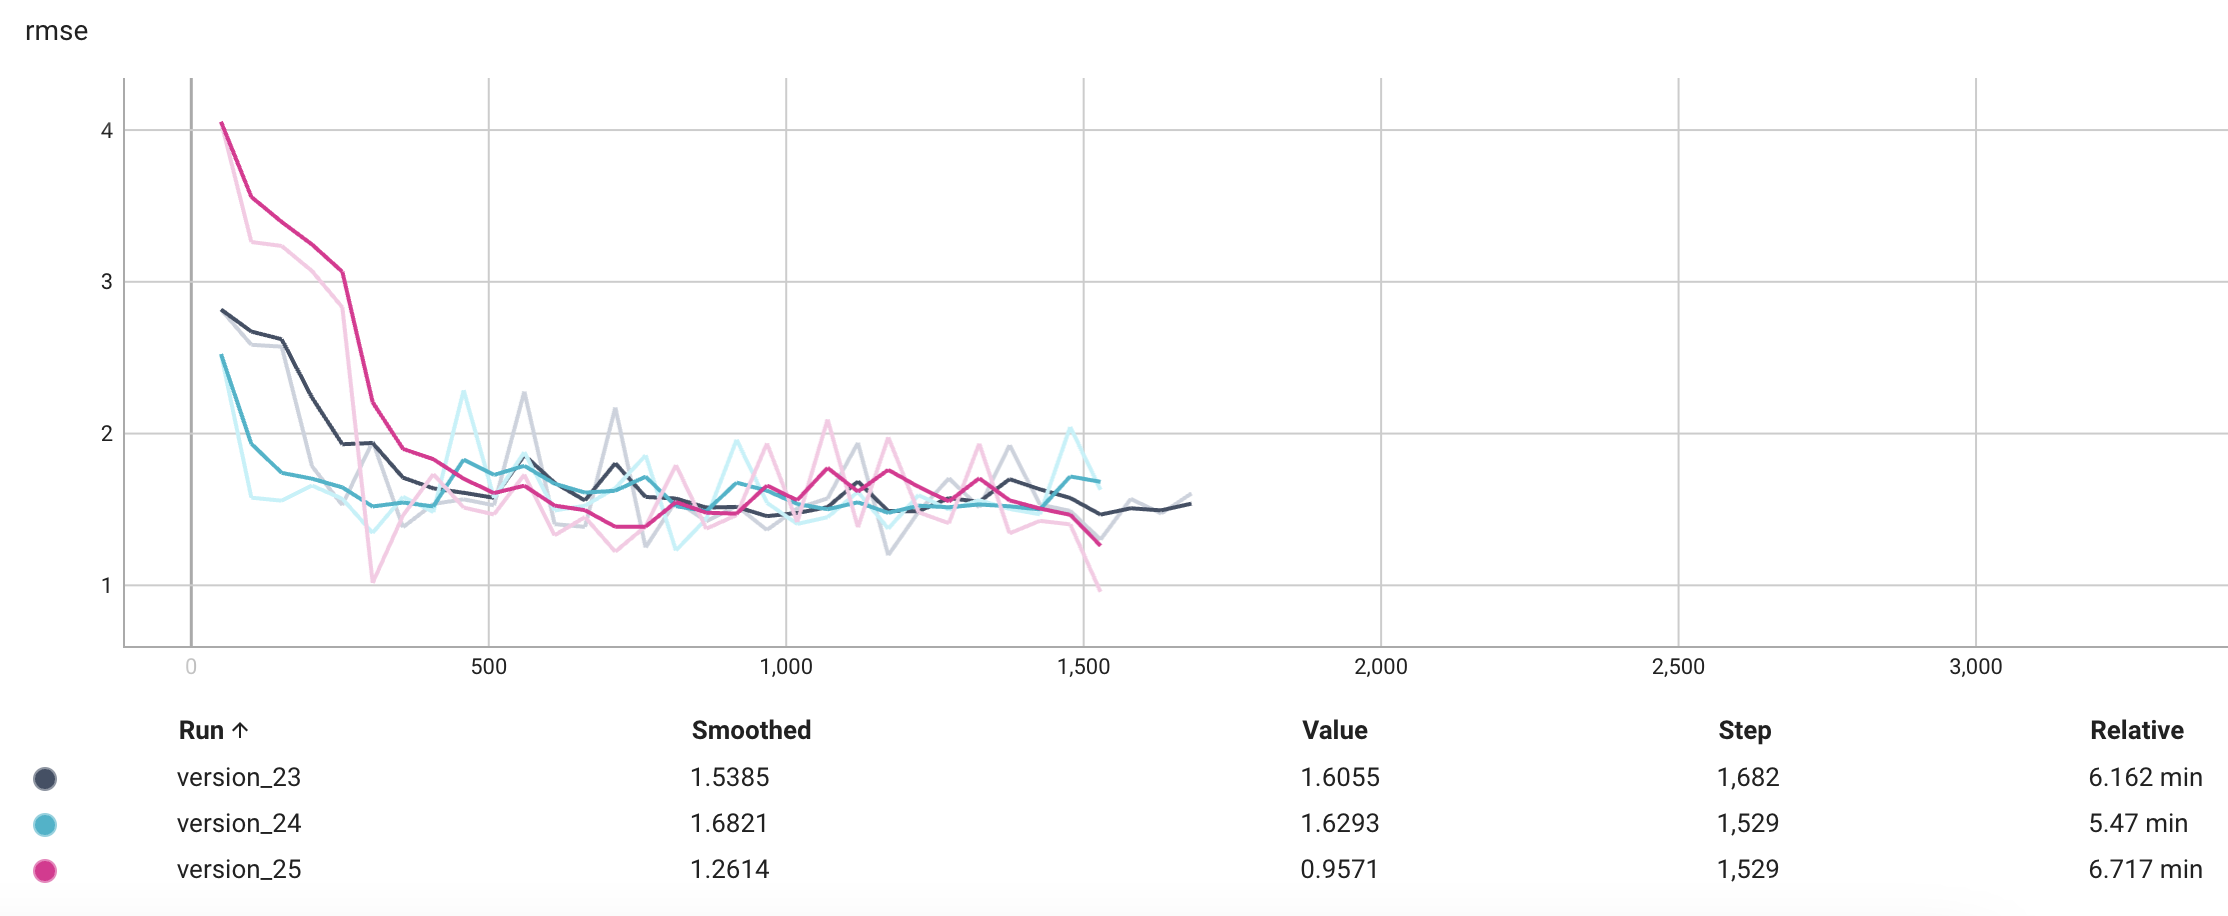

* version_23 + 24: SGD + ExponentialLR (choice 0)
* versio 25: AdamW + OneCycleLR (choice 2)

In [28]:
OPTIM_LR_SCHED_CHOICE=2  # choice out of 3 sample combinations, see configure_optimizers function

In [29]:
# copied from https://github.com/JunjH/Revisiting_Single_Depth_Estimation

class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.edge_conv = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=False)
        edge_kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        edge_ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        edge_k = np.stack((edge_kx, edge_ky))

        edge_k = torch.from_numpy(edge_k).float().view(2, 1, 3, 3)
        self.edge_conv.weight = nn.Parameter(edge_k)

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = self.edge_conv(x)
        out = out.contiguous().view(-1, 2, x.size(2), x.size(3))

        return out

In [31]:
num_epochs=30

class DepthUNet(L.LightningModule):
    """Flexible small implementation with a small backbone (mobilenet-v2)"""
    
    def __init__(self):
        super().__init__()
        self.cos = nn.CosineSimilarity(dim=1, eps=0)
        self.get_gradient = Sobel()
        self.net = smp.Unet(encoder_name='mobilenet_v2', encoder_weights='imagenet', in_channels=3, classes=1)

    def forward(self, x):
        image, depth = x['image'], x['depth_map']
        output = self.net(image)
        output = F.interpolate(output, size=[depth.size(2), depth.size(3)],
                               mode='bilinear', align_corners=True)
        return output

    def training_step(self, x, idx):
        """Simple loss functions don't do it for the monocular depth estimation task, so combinations
        of different losses seem to work best. This one is from:
        https://github.com/JunjH/Revisiting_Single_Depth_Estimation/blob/master/train.py"""

        image, depth = x['image'], x['depth_map']

        # forward
        output = self.net(image)

        # loss: depth
        loss_depth = torch.log(torch.abs(output - depth) + 0.5).mean()

        # loss: grad
        depth_grad = self.get_gradient(depth)
        output_grad = self.get_gradient(output)
        depth_grad_dx = depth_grad[:, 0, :, :].contiguous().view_as(depth)
        depth_grad_dy = depth_grad[:, 1, :, :].contiguous().view_as(depth)
        output_grad_dx = output_grad[:, 0, :, :].contiguous().view_as(depth)
        output_grad_dy = output_grad[:, 1, :, :].contiguous().view_as(depth)

        loss_dx = torch.log(torch.abs(output_grad_dx - depth_grad_dx) + 0.5).mean()
        loss_dy = torch.log(torch.abs(output_grad_dy - depth_grad_dy) + 0.5).mean()

        # loss: normal
        ones = torch.ones(depth.size(0), 1, depth.size(2), depth.size(3), requires_grad=True).type_as(image)
        depth_normal = torch.cat((-depth_grad_dx, -depth_grad_dy, ones), 1)
        output_normal = torch.cat((-output_grad_dx, -output_grad_dy, ones), 1)

        loss_normal = torch.abs(1 - self.cos(output_normal, depth_normal)).mean()

        # loss
        loss = loss_depth \
            + 1 * (loss_dx + loss_dy) \
            + 1 * loss_normal

        self.log_dict({'l_d': loss_depth, 'l_g': loss_dx + loss_dy, 'l_n': loss_normal},
                      prog_bar=True)
        return loss

    def validation_step(self, x, idx):
        image, depth = x['image'], x['depth_map']

        # forward
        output = self.net(image)
        output = torch.nn.functional.interpolate(output, size=[depth.size(2), depth.size(3)],
                                                 mode='bilinear', align_corners=True)

        # calc metrics
        d_metrics: DepthMetrics = evaluate_depth_metrics(output, depth)

        self.log_dict(dataclasses.asdict(d_metrics))

        self.validation_step_outputs = d_metrics

        return d_metrics.mse  # for rmse calculation

    def on_validation_epoch_end(self):
        self.log('rmse', np.sqrt(self.validation_step_outputs.mse))


    def configure_optimizers(self):
        """Here the different optimizers and LR schedulers can be configured.
        
        As per the requirement of the task I demonstrate the use of different optims and LR schedulers
        in this section. To switch between the 3 choices I have pre-configured, just change the choice 
        variable.
        """
        lr=1e-3
        epochs=num_epochs

        # optims
        sgd = torch.optim.SGD(self.parameters(), lr=lr, momentum=0.9)
        adamw = torch.optim.AdamW(self.parameters(), lr=lr)

        # LR schedulers
        exp = torch.optim.lr_scheduler.ExponentialLR
        onecycle = torch.optim.lr_scheduler.OneCycleLR
        

        choices = [
            {'optimizer': sgd,
             'lr_scheduler': exp(sgd, 0.9)},
            {'optimizer': adamw,
             'lr_scheduler': exp(adamw, 0.9)},
            {'optimizer': adamw,
             'lr_scheduler': onecycle(adamw, lr, total_steps=epochs)}
        ]

        choice = choices[OPTIM_LR_SCHED_CHOICE]
        
        return choice

## Train

In [26]:
depth_net = DepthUNet()
tensorboard = pl_loggers.TensorBoardLogger(save_dir="")
trainer = L.Trainer(default_root_dir="checkpoints/", logger=tensorboard, max_epochs=num_epochs) # limit_train_batches=0.05, limit_val_batches=0.01
ds.set_transform(my_transforms)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [27]:
batch_size = 8

trainer.fit(depth_net, 
            DataLoader(ds_train, batch_size=batch_size), 
            DataLoader(ds_validation, batch_size=batch_size))


  | Name         | Type             | Params
--------------------------------------------------
0 | cos          | CosineSimilarity | 0     
1 | get_gradient | Sobel            | 18    
2 | net          | Unet             | 6.6 M 
--------------------------------------------------
6.6 M     Trainable params
18        Non-trainable params
6.6 M     Total params
26.516    Total estimated model params size (MB)


Sanity Checking: |                                                                                  | 0/? [00:…

/Users/daniel/git/depth-estimation/depth-estimation_orig/.venv2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/daniel/git/depth-estimation/depth-estimation_orig/.venv2/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                                                                         | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

Validation: |                                                                                       | 0/? [00:…

`Trainer.fit` stopped: `max_epochs=30` reached.
